In [45]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats


0.4892113160653944
0.4968062812277118
0.5046912399289624
0.5203818163596011
0.5464954773707914
0.5788723441622825
0.612202385030555
0.6430029073675683
0.6698026640023764
0.6924000978066596
0.7111851979988834
0.7267367838324124
0.7396319447840839
0.7503741179048657
0.759377091603762
0.7669716077141828
0.77341896844687
0.7789251124018991
0.7836528339255853


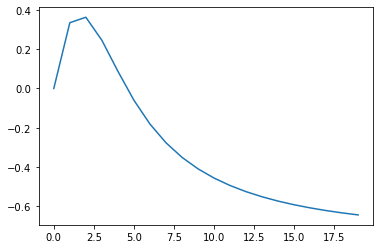

In [112]:
def model():
    ## Parameters of the model
    mm = 1 #switching parameter gamma in Brock Hommes
    pstar = 0
    # the central bank's inflation target
    eprational=1 # if all agents have rational forecast of inflation this parameter is 1
    epextrapol=0 # if all agents use inflation extrapolation this parameter is 1
    a1 = 0.5 #coefficient of expected output in output equation
    a2 = 0.2 #a is the interest elasticity of output demand
    a3 = 0.25
    b1 = 0.5 #b1 is coefficient of expected inflation in inflation equation
    b2 = 0.05 #b2 is coefficient of output in inflation equation
    b3 = 0.03
    c1 = 1.5 #c1 is coefficient of inflation in Taylor equation
    c2 = 0.5 #c2 is coefficient of output in Taylor equation
    c3 = 0.5 #interest smoothing parameter in Taylor equation
    f1 = 0.6 #Public expenditure smoothing in fiscal rule
    f2 = 0.4 #Coefficient of output in fiscal rule
    f3 = 0.03 #Coefficient of public debt in fiscal rule
    r = 0.01 #S.S. interest rate
    h1 = 0.4 #Coefficient of public expenditure in debt equation
    h2 = 1.6 #Coefficient of output in debt equation
    tau = 0.3 #Income tax rate
    gamma = 2 #Intensity of choice parameter
   
    A = np.array([[1,-b2],[-a2*c1,1-a2*c2]])
    B = np.array([[b1, 0],[-a2, a1]])
    C = np.array([[1-b1,0],[0,1-a1]])
    T = 20
    TI = 250
    K = 50
    #length of period to compute divergence
    sigma1 = 0.5
    #standard deviation shocks output
    #standard deviation shocks inflation
    sigma2 = 0.5
    sigma3 = 0.5
    #standard deviation shocks Taylor
    rho=0.5 #Memory parameter
    #rho in mean squares errors
    rhoout=0.0
    #rho in shocks output
    rhoinf=0.0
    #rho in shocks inflation
    #rho in shocks Taylor
    rhotayl=0.0
    rhoBH=0.0
    epfs=pstar
    #forecast inflation targeters
    p = np.zeros(T)
    y = np.zeros(T)
    plagt = np.zeros(T)
    ylagt = np.zeros(T)
    r = np.zeros(T)
    epf = np.zeros(T)
    epc = np.zeros(T)
    ep = np.zeros(T)
    ey = np.zeros(T)
    CRp = np.zeros(T)
    FRp = np.zeros(T)
    alfapt = np.zeros(T)
    eyfunt = np.zeros(T)
    CRy = np.zeros(T)
    FRy = np.zeros(T)
    alfayt = np.zeros(T)
    anspirits = np.zeros(T)
    epsilont = np.zeros(T)
    etat = np.zeros(T)
    ut = np.zeros(T)


    #################################################
    #heuristic model
    #################################################
    alfap=0.5
    alfay=0.5
    K1=K+1
    for t in range(1,T):
        epsilont[t]=rhoout*epsilont[t-1]+sigma1*1#shocks in output equation [demand shock]
        etat[t]=rhoinf*etat[t-1]+sigma2*1#shocks in inflation equation [supply shock]
        ut[t]=rhotayl*ut[t-1]+sigma3*1#shocks in Taylor rule [interest rate shock]
        epsilon=epsilont[t]
        eta=etat[t]
        u=ut[t]
        shocks=np.array([eta,a2*u+epsilon])
        epcs=p[t-1]
        if eprational==1:
            epcs=pstar

        eps=alfap*epcs+(1-alfap)*epfs
        if epextrapol==1:
            eps=p[t-1]
        # eps is expected inflation in next period
        eychar=y[t-1]
        eyfun=0+1/2
        eyfunt[t]=eyfun
        eys=alfay*eychar+(1-alfay)*eyfun
        forecast=np.array([eps, eys])
        plag=p[t-1]
        ylag=y[t-1]
        rlag=r[t-1]
        lag=np.array([plag,ylag])
        smooth=np.array([0,a2*c3])
        D=np.dot(B,forecast)+np.dot(C,lag)+smooth*rlag+shocks

        X= np.linalg.solve(A,D)
        p[t]=X[0]
        
        y[t]=X[1]
        r[t]=c1*p[t]+c2*y[t]+c3*r[t-1]+u
        #if square==1
        #    r[t]=c1*[p[t]]^2+c2*y[t]+c3*r[t-1]+u
        #end
        plagt[t]=p[t-1]
        ylagt[t]=y[t-1]
        CRp[t]=rho*CRp[t-1]-(1-rho)*(epcs-p[t])**2
        FRp[t]=rho*FRp[t-1]-(1-rho)*(epfs-p[t])**2
        CRy[t]=rho*CRy[t-1]-(1-rho)*(eychar-y[t])**2
        FRy[t]=rho*FRy[t-1]-(1-rho)*(eyfun-y[t])**2

        alfap=rhoBH*alfapt[t-1]+(1-rhoBH)*np.exp(mm*CRp[t])/(np.exp(mm*CRp[t])+np.exp(mm*FRp[t]))
        alfay=rhoBH*alfayt[t-1]+(1-rhoBH)*np.exp(mm*CRy[t])/(np.exp(mm*CRy[t])+np.exp(mm*FRy[t]))
        alfapt[t]=alfap
        alfayt[t]=alfay
        if eychar>0:
            anspirits[t]=alfay
        if eychar<0:
            anspirits[t]=1-alfay

    autocory=np.corrcoef(y, ylagt)
    autocorp=np.corrcoef(p, plagt)
    coroutputanimal=np.corrcoef(y, anspirits)
    ##mean,median, max, min, standard deviation, kurtosis
    Kurt=stats.kurtosis(y, fisher = False)
    ##Jarque-Bera test
    #[jb, pvalue, jbstat]=jbtest(y, 0.05)
    stats.jarque_bera(y)